In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.models import resnet50, ResNet50_Weights
import os
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


In [6]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Runing on {str(device)}")

# Define dataset paths
torch_train_path = "./animals10_train_argumentation.pt"
torch_test_path = "./animals10_test_argumentation.pt"
torch_val_path = "./animals10_val_argumentation.pt"

# Define class names
class_names = ["cane", "cavallo", "elefante", "farfalla", "gallina", 
               "gatto", "mucca", "pecora", "ragno", "scoiattolo"]

class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
num_classes = len(class_names)

# Load dataset from Torch tensor file
print("Loading dataset from Torch tensor file...")
train_data = torch.load(torch_train_path)
print("Dataset loaded successfully.")
test_data = torch.load(torch_test_path)
print("Test dataset loaded successfully.")
val_dataset = torch.load(torch_val_path)
print("Validation dataset loaded successfully.")
train_images, train_labels = train_data["images"], train_data["labels"]
test_images, test_labels = test_data["images"], test_data["labels"]
val_images, val_labels = val_dataset["images"], val_dataset["labels"]

train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)
val_dataset = TensorDataset(val_images, val_labels)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

Runing on cuda
Loading dataset from Torch tensor file...


C:\Users\Hizan\AppData\Local\Temp\ipykernel_35868\1296517521.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(torch_train_path)


Dataset loaded successfully.


C:\Users\Hizan\AppData\Local\Temp\ipykernel_35868\1296517521.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load(torch_test_path)


Test dataset loaded successfully.


C:\Users\Hizan\AppData\Local\Temp\ipykernel_35868\1296517521.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  val_dataset = torch.load(torch_val_path)


Validation dataset loaded successfully.
Train samples: 18325, Val samples: 3926, Test samples: 3928


In [7]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model.to(device)
print(device)

# Replace the final classification layer (model.fc) for 10 classes:
num_ftrs = model.fc.in_features  # typically 2048 for ResNet50
model.fc = nn.Linear(num_ftrs, num_classes)
model.to(device)
# ------------------------------------------------
# 5. Define Loss and Optimizer
# ------------------------------------------------

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Adjust as needed

epochs = 10

cuda


In [9]:
def plot_loss_and_accuracy(train_losses, val_losses, train_accs, val_accs):
    """
    Plots the training/validation loss and accuracy curves in separate charts.
    """
    # Plot loss
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure()
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()
    plt.show()

In [10]:
# Testing

model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for images_batch, labels_batch in test_loader:
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.to(device)
        
        outputs = model(images_batch)
        loss = criterion(outputs, labels_batch)
        
        test_loss += loss.item() * images_batch.size(0)
        _, predicted = outputs.max(1)
        test_correct += predicted.eq(labels_batch).sum().item()
        test_total += labels_batch.size(0)

test_loss /= len(test_loader.dataset)
test_acc = test_correct / test_total
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Test Loss: 2.3121, Test Acc: 0.0911


In [11]:
train_losses = []
train_accs   = []
val_losses   = []
val_accs     = []

for epoch in range(epochs):
    # --- Training ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images_batch, labels_batch in train_loader:
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        
        # Track training loss
        running_loss += loss.item() * images_batch.size(0)
        
        # Compute training accuracy
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels_batch).sum().item()
        total += labels_batch.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    
    print(f"Epoch [{epoch+1}/{epochs}] - "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")

    # --- Validation ---
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images_batch, labels_batch in val_loader:
            images_batch = images_batch.to(device)
            labels_batch = labels_batch.to(device)

            outputs = model(images_batch)
            loss = criterion(outputs, labels_batch)
            
            # Track validation loss
            val_running_loss += loss.item() * images_batch.size(0)
            # Compute validation accuracy
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels_batch).sum().item()
            val_total += labels_batch.size(0)
    
    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_acc = val_correct / val_total
    
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)
    
    print(f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}\n")


Epoch [1/10] - Train Loss: 0.2694, Train Acc: 0.9333
Val Loss: 0.0929, Val Acc: 0.9740

Epoch [2/10] - Train Loss: 0.0594, Train Acc: 0.9841
Val Loss: 0.1049, Val Acc: 0.9715

Epoch [3/10] - Train Loss: 0.0324, Train Acc: 0.9903
Val Loss: 0.1136, Val Acc: 0.9710

Epoch [4/10] - Train Loss: 0.0314, Train Acc: 0.9905
Val Loss: 0.1183, Val Acc: 0.9689

Epoch [5/10] - Train Loss: 0.0245, Train Acc: 0.9926
Val Loss: 0.1174, Val Acc: 0.9712

Epoch [6/10] - Train Loss: 0.0216, Train Acc: 0.9937
Val Loss: 0.1194, Val Acc: 0.9735

Epoch [7/10] - Train Loss: 0.0188, Train Acc: 0.9943
Val Loss: 0.1713, Val Acc: 0.9577

Epoch [8/10] - Train Loss: 0.0212, Train Acc: 0.9925
Val Loss: 0.1393, Val Acc: 0.9648

Epoch [9/10] - Train Loss: 0.0200, Train Acc: 0.9943
Val Loss: 0.1162, Val Acc: 0.9753

Epoch [10/10] - Train Loss: 0.0158, Train Acc: 0.9957
Val Loss: 0.1125, Val Acc: 0.9733



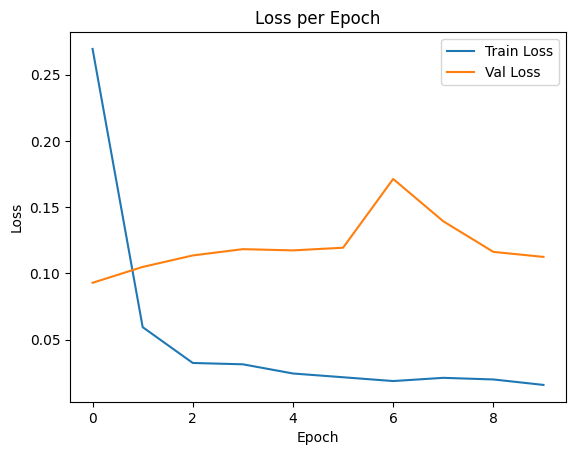

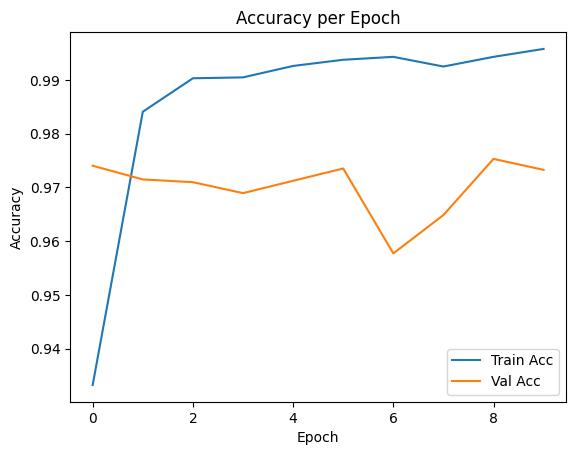

In [12]:
# Plot Loss and Accuracy
plot_loss_and_accuracy(train_losses, val_losses, train_accs, val_accs)

In [13]:
# Testing

model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for images_batch, labels_batch in test_loader:
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.to(device)
        
        outputs = model(images_batch)
        loss = criterion(outputs, labels_batch)
        
        test_loss += loss.item() * images_batch.size(0)
        _, predicted = outputs.max(1)
        test_correct += predicted.eq(labels_batch).sum().item()
        test_total += labels_batch.size(0)

test_loss /= len(test_loader.dataset)
test_acc = test_correct / test_total
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Test Loss: 0.0978, Test Acc: 0.9751
